# Understanding Hired Rides in NYC - Group 28

### Code by Devangi Gaikwad & Luqman Bharoto



## Project Setup

Before data processing, the notebook requires imports and other constants as well as data sources as outlined in the cells below.

In [1]:
#This cell conatins all import statements utilised in this notebook to successfully run the code. 

import requests
import bs4
import re
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import geopandas as gpd
from skimpy import clean_columns
import sqlalchemy as db
import matplotlib.pyplot as plt
import math
import os
import io


import matplotlib

import seaborn as sns
import folium 
from folium.plugins import HeatMapWithTime
import sqlite3
from sqlite3 import connect

In [2]:
#All the constants and file paths called/ used in this notebook. 
#Ensure that all files are stored in the same folder as this notebook. 


TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_DATA = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
ny_lat0, ny_lon0 = NEW_YORK_BOX_COORDS[0]
ny_lat1, ny_lon1 = NEW_YORK_BOX_COORDS[1]

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

#Specifying coordintes for airports to be used later in visualization 3 
LGA_coordinate = ((40.766762,-73.889279),(40.786455,-73.855033)) #LGA box coordinates
JFK_coordinate = ((40.624832,-73.820744),(40.666382,-73.748131)) #JFK box coordinates
EWR_coordinate = ((40.670809,-74.193163),(40.707775,-74.153509)) #EWR box coordinates

#Unpacking JFK airport coordinates
jfk_lat0, jfk_lon0 = JFK_coordinate[0]
jfk_lat1, jfk_lon1 = JFK_coordinate[1]

#Unpacking LGA airport coordinates
lga_lat0, lga_lon0 = LGA_coordinate[0]
lga_lat1, lga_lon1 = LGA_coordinate[1]

#Unpacking EWR airport coordinates
ewr_lat0, ewr_lon0 = EWR_coordinate[0]
ewr_lat1, ewr_lon1 = EWR_coordinate[1]

## Part 1: Data Preprocessing

This section cleans and pre-processes all the data required for understanding and visualizing later.
At the end of the data preprocessing, all dataframes will only consist of the required columns and in the required format.
For example, the datetime library is used to convert the datetime objects in the datetime columns to our preferred format. 

### Data lookup from taxi_zones.shp


Reading the .shp file for filtering data that lies within the NYC coordinates given above. 


In [3]:
#Loading the .shp file usign geopandas
taxi_zone = gpd.read_file(r"taxi_zones.shp")

In [4]:
# Get the center of each polygon
taxi_zone = taxi_zone.to_crs(4326)
taxi_zone["lon"] = taxi_zone.centroid.x
taxi_zone["lat"] = taxi_zone.centroid.y

# make sure that the coodinate is located inside NY bounding box
taxi_zone = taxi_zone[(taxi_zone["lon"] > ny_lon0) & (taxi_zone["lon"] < ny_lon1)]
taxi_zone = taxi_zone[(taxi_zone["lat"] > ny_lat0) & (taxi_zone["lat"] < ny_lat1)]

# Mark the location id for JFK airport
taxi_zone["airport_JFK"] = np.where(taxi_zone[taxi_zone["lon"] > jfk_lon0] & taxi_zone[taxi_zone["lon"] < jfk_lon1] 
                            & taxi_zone[taxi_zone["lat"] > jfk_lat0] & taxi_zone[taxi_zone["lat"] < jfk_lat1], 
                            True, False)

# Mark the location id for LGA airport
taxi_zone["airport_LGA"] = np.where(taxi_zone[taxi_zone["lon"] > lga_lon0] & taxi_zone[taxi_zone["lon"] < lga_lon1] 
                            & taxi_zone[taxi_zone["lat"] > lga_lat0] & taxi_zone[taxi_zone["lat"] < lga_lat1], 
                            True, False)

# Mark the location id for JFK airport
taxi_zone["airport_EWR"] = np.where(taxi_zone[taxi_zone["lon"] > ewr_lon0] & taxi_zone[taxi_zone["lon"] < ewr_lon1] 
                            & taxi_zone[taxi_zone["lat"] > ewr_lat0] & taxi_zone[taxi_zone["lat"] < ewr_lat1], 
                            True, False)

#mapping airpot location
mapping_airport = {False: "Non-Airport", "airport_JFK": "JFK", "airport_LGA": "LGA", "airport_EWR": "EWR"}

airport_loc = taxi_zone.filter(like='airport_')
taxi_zone["airport"] = (airport_loc.idxmax(axis=1).map(mapping_airport).where(airport_loc.any(axis=1), 
                                                                              mapping_airport[False]))

/tmp/ipykernel_2774/619535230.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone["lon"] = taxi_zone.centroid.x
/tmp/ipykernel_2774/619535230.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone["lat"] = taxi_zone.centroid.y
/tmp/ipykernel_2774/619535230.py:11: FutureWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  taxi_zone["airport_JFK"] = np.where(taxi_zone[taxi_zone["lon"] > jfk_lon0] & taxi_zone[taxi_zone["lon"] < jfk_lon1]
/usr/local/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_2774/619535230.py:11: FutureWarning: 

In [5]:
#Creating a dataframe to handle the location data

df_taxi_zone = taxi_zone[["LocationID","airport"]].copy()

df_taxi_zone["latitude"] = taxi_zone.lat
df_taxi_zone["longitude"] = taxi_zone.lon

df_taxi_zone = df_taxi_zone.dropna()


### Calculating distance

The distance is an integral component in analyzing the uber vs yellow taxi data. 

In [7]:
def calculate_distance(from_coord, to_coord):
    """
    Finding the distnce in km between any two coordinates
    """
    result = []
    
    for data in range(max(len(from_coord), len(to_coord))):
        lat1, lon1 = from_coord[data]
        lat2, lon2 = to_coord[data]
                      
        #method to convert a degree value into radians
        lon1 = math.radians(lon1)
        lon2 = math.radians(lon2)
        lat1 = math.radians(lat1)
        lat2 = math.radians(lat2)
        
        #Haversine Formula
        diff_lon = lon2 - lon1 
        diff_lat = lat2 - lat1
        
        a = math.sin(diff_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(diff_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
        # Radius of earth in kilometers. Use 3956 for miles
        r = 6371
                      
        #calculate the result
        distance = r*c
        result.append(distance)
    
    distance_series = pd.Series(result)
                      
    return distance_series

In [8]:
def add_distance_column_1(dataframe): 
    """
    Removing locations outside the three airports for visualization 3 below. 
    Non-airport data points is hardcoded for all 2009 and 2010 data because we compare it with the airport location data.
    This function only handles data for 2009 and 2010 because both tables have different initial data format compared to
    the other years.
    """
    dataframe["dropoff_location"] = "Non-Airport" # IT'S JUST two out of six years, so it wouldn't hurt at all
    
    #calculate distance
    dataframe["pickup_coordinate"] = pd.Series(zip(dataframe["pickup_latitude"], dataframe["pickup_longitude"]))
    dataframe["dropoff_coordinate"] = pd.Series(zip(dataframe["dropoff_latitude"], dataframe["dropoff_longitude"]))
    dataframe["distance"] = calculate_distance(dataframe["pickup_coordinate"], dataframe["dropoff_coordinate"])
    
    return dataframe

In [9]:
def add_distance_column_2(dataframe):
    """
    This function only handles data from 2011 to 2015 because these tables have different data format compared to 2009,2010.

    """
    #merge main dataframe with the df_location based on LocationID
    dataframe = dataframe.merge(df_taxi_zone, left_on='PULocationID', right_on='LocationID')
    dataframe = dataframe.merge(df_taxi_zone, left_on='DOLocationID', right_on='LocationID')
    dataframe = dataframe.rename(columns={"latitude_x":"pickup_latitude", "longitude_x":"pickup_longitude",
                                         "latitude_y":"dropoff_latitude", "longitude_y":"dropoff_longitude",
                                         "airport_x": "pickup_location", "airport_y": "dropoff_location"})
    
    dataframe["pickup_coordinate"] = pd.Series(zip(dataframe["pickup_latitude"], dataframe["pickup_longitude"]))
    dataframe["dropoff_coordinate"] = pd.Series(zip(dataframe["dropoff_latitude"], dataframe["dropoff_longitude"]))
    
    dataframe["distance"] = calculate_distance(dataframe["pickup_coordinate"], dataframe["dropoff_coordinate"])
    dataframe = dataframe.drop(columns=["LocationID_x","LocationID_y","pickup_coordinate","dropoff_coordinate"])
    dataframe = dataframe.dropna()
    
    return dataframe

### Processing Taxi Data

Defining functions for loading and filtering/ cleaning data for yellow taxis from the listed website using html parsing. 

In [10]:
def find_taxi_csv_urls():
    """
    Takes the NYC Taxi Data URL and returns a list consisting of monthly NYC taxi data's URLs 
    """
    response = requests.get(TAXI_URL)
    html = response.content
    
    #Find taxi parquet links
    soup = bs4.BeautifulSoup(html, 'html.parser')
    result = [a['href'] for a in soup.find_all('a', title="Yellow Taxi Trip Records")]
    return result

In [11]:
def get_and_clean_month_taxi_data(url):
    """
    Takes a string of URL and returns a NYC taxi dataframe
    """
    dataframe = pd.DataFrame(None)
    match_1 = re.search(r"\w+(?P<year>2009|201[012345])-\w+\.parquet", url)
    #match_1 = re.search(r"\w+(?P<year>2022)-01.parquet", url)
    #keep in mind that currently we only take 2022-01 data to make the preprocessing more efficient, we can update the REGEX once we wrapped up all the sections
    match_2 = re.search(r"\w+2015-0[789]|2015-1[012].parquet", url)
    
    if (match_1 is None) or (match_2 == True):
        pass
    elif not match_2:
        year = match_1.group("year")
        response = requests.get(url)
        
        with open(match_1.group(), "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
                    
        with open(match_1.group(), "r") as f:
            if year == "2009":
                dataframe = pd.read_parquet(match_1.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                
                #rename columns
                dataframe = dataframe.rename(columns={"Trip_Pickup_DateTime":"tpep_pickup_datetime",
                                                     "Tip_Amt":"tip_amount",
                                                     "Start_Lon":"pickup_longitude",
                                                     "Start_Lat":"pickup_latitude",
                                                     "End_Lon": "dropoff_longitude",
                                                     "End_Lat": "dropoff_latitude"})
                
                #just take important columns
                dataframe = dataframe[["tpep_pickup_datetime", "pickup_longitude", "pickup_latitude",
                                      "dropoff_longitude", "dropoff_latitude","tip_amount"]]

                dataframe = add_distance_column_1(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()
                
                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                                       'dropoff_latitude','tip_amount','dropoff_location','distance']]
                dataframe = dataframe.dropna(subset=["distance"])
                
            elif year == "2010":
                dataframe = pd.read_parquet(match_1.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                
                dataframe = dataframe.rename(columns={"pickup_datetime":"tpep_pickup_datetime"})
                
                #just take important columns
                dataframe = dataframe[["tpep_pickup_datetime", "pickup_longitude", "pickup_latitude",
                                      "dropoff_longitude", "dropoff_latitude","tip_amount"]]
                
                dataframe = add_distance_column_1(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()
                
                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                                       'dropoff_latitude','tip_amount','dropoff_location','distance']]
                dataframe = dataframe.dropna(subset=["distance"])
                
            else:    
                dataframe = pd.read_parquet(match_1.group(), engine='pyarrow')
                dataframe = dataframe.sample(frac=0.01, random_state=1)
                dataframe = dataframe.reset_index(drop=True)
                dataframe = dataframe[['tpep_pickup_datetime','PULocationID', 'DOLocationID','tip_amount']]

                dataframe = add_distance_column_2(dataframe)
                dataframe["tpep_pickup_date"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.date
                dataframe["tpep_pickup_hour"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.hour
                dataframe["tpep_pickup_day"] = pd.to_datetime(dataframe["tpep_pickup_datetime"]).dt.day_name()

                dataframe = dataframe[['tpep_pickup_date','tpep_pickup_day','tpep_pickup_hour',
                                       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                                       'dropoff_latitude','tip_amount','dropoff_location','distance']]
                dataframe = dataframe.dropna(subset=["distance"])
                            
    return dataframe

In [12]:
def get_and_clean_taxi_data():
    """
    Returns a consolidated dataframe of taxi_data
    This function will combine get_and_clean_month_taxi_data(url) and find_taxi_csv_urls()
    """
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    return taxi_data

### Processing Uber Data

Defining functions for loading and cleaning data for uber trips from the csv file.

In [13]:
def load_and_clean_uber_data(csv_file):
    """
    Takes a string of csv file name, defined in cell 1
    Returns the uber_dataframe
    """
    df_uber = pd.read_csv(csv_file)
    
    #renaming old df without creating a copy 
    df_uber.rename(columns={'key': 'date_time', 'Unnamed: 0': 'location_id'}, inplace=True)
    
    #constructing new columns as a function input
    df_uber["pickup_coordinate"] = list(zip(df_uber.pickup_latitude, df_uber.pickup_longitude))
    df_uber["dropoff_coordinate"] = list(zip(df_uber.dropoff_latitude, df_uber.dropoff_longitude))
    
    #calculate distance
    df_uber["distance"] = calculate_distance(df_uber["pickup_coordinate"], df_uber["dropoff_coordinate"])
    
    #make sure that the coordinate is located inside the NY bounding box
    df_uber = df_uber[(df_uber["pickup_longitude"] > ny_lon0) & (df_uber["pickup_longitude"] < ny_lon1)]
    df_uber = df_uber[(df_uber["dropoff_longitude"] > ny_lon0) & (df_uber["dropoff_longitude"] < ny_lon1)]
    df_uber = df_uber[(df_uber["pickup_latitude"] > ny_lat0) & (df_uber["pickup_latitude"] < ny_lat1)]
    df_uber = df_uber[(df_uber["dropoff_latitude"] > ny_lat0) & (df_uber["dropoff_latitude"] < ny_lat1)]
    
    #handle the datetime format
    df_uber["order_date"] = pd.to_datetime(df_uber["date_time"]).dt.date
    df_uber["order_time"] = pd.to_datetime(df_uber["date_time"]).dt.hour
    df_uber["order_day"] = pd.to_datetime(df_uber["date_time"]).dt.day_name()
    
    df_uber["pickup_date"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.date
    df_uber["pickup_time"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.hour
    df_uber["pickup_day"] = pd.to_datetime(df_uber["pickup_datetime"]).dt.day_name()
    
    df_uber = df_uber.drop(columns=["date_time", "pickup_datetime"])
    
    return df_uber

In [14]:
def get_uber_data():

    """
    Returns the cleaned uber_dataframe by calling up load_and_clean_uber_data(csv_file)
    """
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    uber_dataframe = uber_dataframe.drop(columns=["pickup_coordinate","dropoff_coordinate"])
    
    uber_dataframe = uber_dataframe[["location_id","fare_amount", 
                                     "pickup_longitude", "pickup_latitude", 
                                     "dropoff_longitude","dropoff_latitude", "passenger_count",
                                     "distance", "order_date","order_time", 
                                     "order_day", "pickup_date",
                                     "pickup_time", "pickup_day"]]
    
    
    return uber_dataframe

### Processing Weather Data

Defining functions for loading and cleaning data for historial weather from the csv file.

In [15]:
def clean_month_weather_data_hourly(csv_file):
    """
    Takes a string of monthly weeather data's csv file name, defined in cell 1
    Returns the hourly weather observation dataframe
    """
    df_weather = pd.read_csv(csv_file, low_memory = False)
    weather_columns = df_weather.columns.tolist()
    result = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE']
    
    for column in weather_columns:
        match = re.search(r"Hourly", column)
        if match is None:
            pass
        else:
            result.append(column)
    
    df_weather_hourly = df_weather[result]
    
    return df_weather_hourly

In [16]:
def clean_month_weather_data_daily(csv_file):
    """
    Takes a string of monthly weeather data's csv file name, defined in cell 1
    Returns the daily weather observation dataframe
    """
    df_weather = pd.read_csv(csv_file, low_memory = False)
    weather_columns = df_weather.columns.tolist()
    result = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE']
    
    for column in weather_columns:
        match = re.search(r"Daily", column)
        if match is None:
            pass
        else:
            result.append(column)
    
    df_weather_daily = df_weather[result]
    
    return df_weather_daily

In [17]:
def load_and_clean_weather_data():
    """
    Returns hourly and daily observation dataframe
    """
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    weather_csv_files = []
    list_dir = os.listdir() #list all file within a directory and store in an array

    for file in list_dir:
        match = re.search(r"(2009|201[012345])_weather.csv", file)
        if match is None:
            pass
        else:
            weather_csv_files.append(match.group())
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    #handle datetime format - hourly data
    hourly_data["ORDER_DATE"] = pd.to_datetime(hourly_data["DATE"]).dt.date
    hourly_data["ORDER_TIME"] = pd.to_datetime(hourly_data["DATE"]).dt.hour
    hourly_data["ORDER_DAY"] = pd.to_datetime(hourly_data["DATE"]).dt.day_name()
    hourly_data = hourly_data.drop(columns=["DATE"])
    
    #handle datetime format - daily data
    daily_data["ORDER_DATE"] = pd.to_datetime(daily_data["DATE"]).dt.date
    daily_data["ORDER_TIME"] = pd.to_datetime(daily_data["DATE"]).dt.hour
    daily_data["ORDER_DAY"] = pd.to_datetime(daily_data["DATE"]).dt.day_name()
    daily_data = daily_data.drop(columns=["DATE"])
    
    hourly_data = hourly_data[["ORDER_DATE", "ORDER_TIME", "ORDER_DAY",
                              "HourlyPrecipitation", "HourlyWindSpeed"]]
   

    daily_data = daily_data[["ORDER_DATE", "ORDER_TIME", "ORDER_DAY",
                              "DailyAverageWindSpeed"]]
    
    return hourly_data, daily_data

### Process All Data

The above functions were the first step to setup processing for the data. 
The cell below calls these functions to actually execute the cleaning process.

In [18]:
#Calling each function defined above to process the data. This step can take a few minutes so take a break, admire the sky
#or stare at the screen with what seems like forever!


taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()


## Part 2: Storing Cleaned Data

After preprocessing all the data, it is stored in a databse for more efficient execution and conserving memory storage. 

In [19]:
#Creating a database to store all the data in tables. 

engine = db.create_engine(DATABASE_URL)
engine

Engine(sqlite:///project.db)

In [20]:
# Using SQLAlchemy to create tables for the dataframes filtered above
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    HourlyPrecipitation REAL,
    HourlyWindSpeed REAL,
    ORDER_DATE DATE,
    ORDER_TIME INTEGER,
    ORDER_DAY STRING
    )
"""
   

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DailyAverageWindSpeed REAL,        
    ORDER_DATE DATE,
    ORDER_TIME INTEGER,
    ORDER_DAY STRING
    )
"""
   
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    tpep_pickup_date DATE,
    tpep_pickup_day STRING,
    tpep_pickup_hour INTEGER,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    tip_amount REAL,
    dropoff_location TEXT,
    distance REAL
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    location_id BIGINT,
    fare_amount REAL,
    pickup_longitude REAL,
    pickup_latitude REAL,
    dropoff_longitude REAL,
    dropoff_latitude REAL,
    pickup_datetime TEXT,
    passenger_count INTEGER,
    distance REAL,
    order_date DATE,
    order_time INTEGER,
    order_day STRING,
    pickup_date DATE,
    pickup_time INTEGER,
    pickup_day STRING
)
"""

In [21]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [22]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(UBER_TRIPS_SCHEMA)
    connection.close()

### Add Data to Database

This subsection adds data to our 'project.db' database. We define the dataframes in the form of a dictionary to append (add) the data.

In [23]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Takes a dictionary as an input. The dictionary will map out the dataframe name into the table name
    Returns a way to convert dataframe into sql
    """
    for key, value in table_to_df_dict.items():
        value.to_sql(key, engine, index=True, index_label="id", if_exists='append')

In [24]:
#creating a dictionary to execute storing the data
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data
}

In [25]:
#Storing all the data into created database
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

Querying the data using SQLAlchemy for better understanding and interpretation.

In [26]:
def write_query_to_file(query, outfile):
    """
    Takes query script as a string as an input and an outfile name
    Returns an .sql file
    """
    with open(outfile, "w") as f:
        f.write(query)

### Query for statements

Each query statement defined below is based on the comment stated in the respective cell.

In [29]:
#QUERY_1 gives the hour of the day that was the most popular to take a Yellow Taxi from 01-2009 through 06-2015
QUERY_1 = """
SELECT tpep_pickup_hour as order_hour,
    COUNT(id) as num_order    
FROM taxi_trips
WHERE tpep_pickup_date BETWEEN "2009-01-01" AND "2015-06-30" 
GROUP BY order_hour
ORDER BY num_order DESC
"""

In [31]:
#QUERY_2 gives the day of the week that was the most popular to take an Uber from 01-2009 through 06-2015
QUERY_2 = """
SELECT order_day,
    COUNT(id) as num_order    
FROM uber_trips
WHERE order_date BETWEEN "2009-01-01" AND "2015-06-30" 
GROUP BY order_day
ORDER BY num_order DESC
"""

In [32]:
#QUERY_3 gives the 95% percentile of distance traveled for all hired trips during July 2013
QUERY_3 = """
WITH data AS (SELECT distance, NTILE(95) OVER (ORDER BY distance) AS percentile
           FROM taxi_trips
           WHERE tpep_pickup_date BETWEEN "2013-07-01" AND "2013-07-31")
SELECT MAX(distance) as distance
FROM data
GROUP BY percentile;
"""

In [33]:
#QUERY_4 gives the top 10 days with the highest number of hired rides for 2009, and the average distance for each day
QUERY_4 = """
SELECT tpep_pickup_date as order_date,
    COUNT(id) as num_order
FROM taxi_trips
WHERE order_date BETWEEN "2009-01-01 AND 2009-12-31"
GROUP BY order_date
ORDER BY num_order DESC
LIMIT 10"""

In [34]:
#QUERY_5 gives the 10 days in 2014 that were the windiest on average, and how many hired trips were made on those days
QUERY_5 = """
WITH taxi_trip AS (
    SELECT tpep_pickup_date as order_date,
        COUNT(id) as num_order    
    FROM taxi_trips
    WHERE tpep_pickup_date BETWEEN "2014-01-01" AND "2014-12-31"
    GROUP BY order_date
    ORDER BY num_order DESC
    ),
    daily_observation_data AS (
    SELECT ORDER_DATE as order_date,
        AVG(DailyAverageWindSpeed) as avg_wind_speed
    FROM daily_weather
    WHERE order_date BETWEEN "2014-01-01" AND "2014-12-31"
    GROUP BY order_date
    ORDER BY avg_wind_speed DESC
    LIMIT 10
    )
SELECT daily_observation_data.order_date,
    daily_observation_data.avg_wind_speed,
    taxi_trip.num_order
FROM daily_observation_data
LEFT JOIN taxi_trip ON daily_observation_data.order_date = taxi_trip.order_date
"""

In [35]:
#QUERY_6 gives data from during Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after,  
# for trips that were taken each hour, and for each hour, the precipitation NYC received and the sustained wind speed
QUERY_6 = """
WITH weather_data AS (
    SELECT ORDER_TIME AS order_hour,
        ROUND(AVG(HourlyWindSpeed),2) wind_speed,
        ROUND(AVG(HourlyPrecipitation),2) precipitation
    FROM hourly_weather
    WHERE ORDER_DATE BETWEEN "2012-10-22" AND "2012-11-06"
    GROUP BY order_hour
), trip_data AS (
    SELECT tpep_pickup_hour as order_hour,
        COUNT(id) as num_order    
    FROM taxi_trips
    WHERE tpep_pickup_date BETWEEN "2012-10-22" AND "2012-11-06"
    GROUP BY order_hour
    ORDER BY num_order DESC
)
SELECT weather_data.order_hour,
    wind_speed,
    precipitation,
    num_order
FROM weather_data
LEFT JOIN trip_data ON weather_data.order_hour = trip_data.order_hour
"""

In [36]:
#Writing every query to a .sql file
write_query_to_file(QUERY_1, "popular_hour_yellow_taxi.sql")
write_query_to_file(QUERY_2, "popular_week_uber.sql")
write_query_to_file(QUERY_3, "95thpercentile_alltrips_Jul2013.sql")
write_query_to_file(QUERY_4, "highest_hired_rides_2009.sql")
write_query_to_file(QUERY_5, "windiestday_hiredtrips_2014.sql")
write_query_to_file(QUERY_6, "hurricane_sandy_week_trips.sql")

## Part 4: Visualizing the Data

The visualizations below help to get a better understanding of the data and further determine predictions or build models.

### Visualization 1: When are the Yellow Taxis busy? 

Making a visualization for QUERY_1 to see what hour of the day was most popular to take a Yellow Taxi

In [53]:
def get_data_for_visual_1():
    """
    Reading the data from the sql query for 1
    """
    conn = sqlite3.connect("project.db")
    dataframe_query_1 = pd.read_sql(QUERY_1, conn)
    dataframe_query_1 = dataframe_query_1.sort_values('order_hour')
    return dataframe_query_1

In [54]:
def plot_visual_query_1(dataframe):
    """
    Plotting a bar chart to see trip orders in the day
    """
    dataframe_query_1 = dataframe
    figure, axes = plt.subplots(figsize=(20, 10))
    tick_labels = list(range(1,25))
    axes.bar(dataframe_query_1["order_hour"], dataframe_query_1["num_order"], 
             tick_label=tick_labels, color = 'lightblue')
    axes.set_title("Orders each Hour of Day from 2009-01-01 to 2015-06-30")
    axes.set_ylabel("Total trip orders")
    
    axes.set_xlabel("Hour of the day")
       
    plt.show()

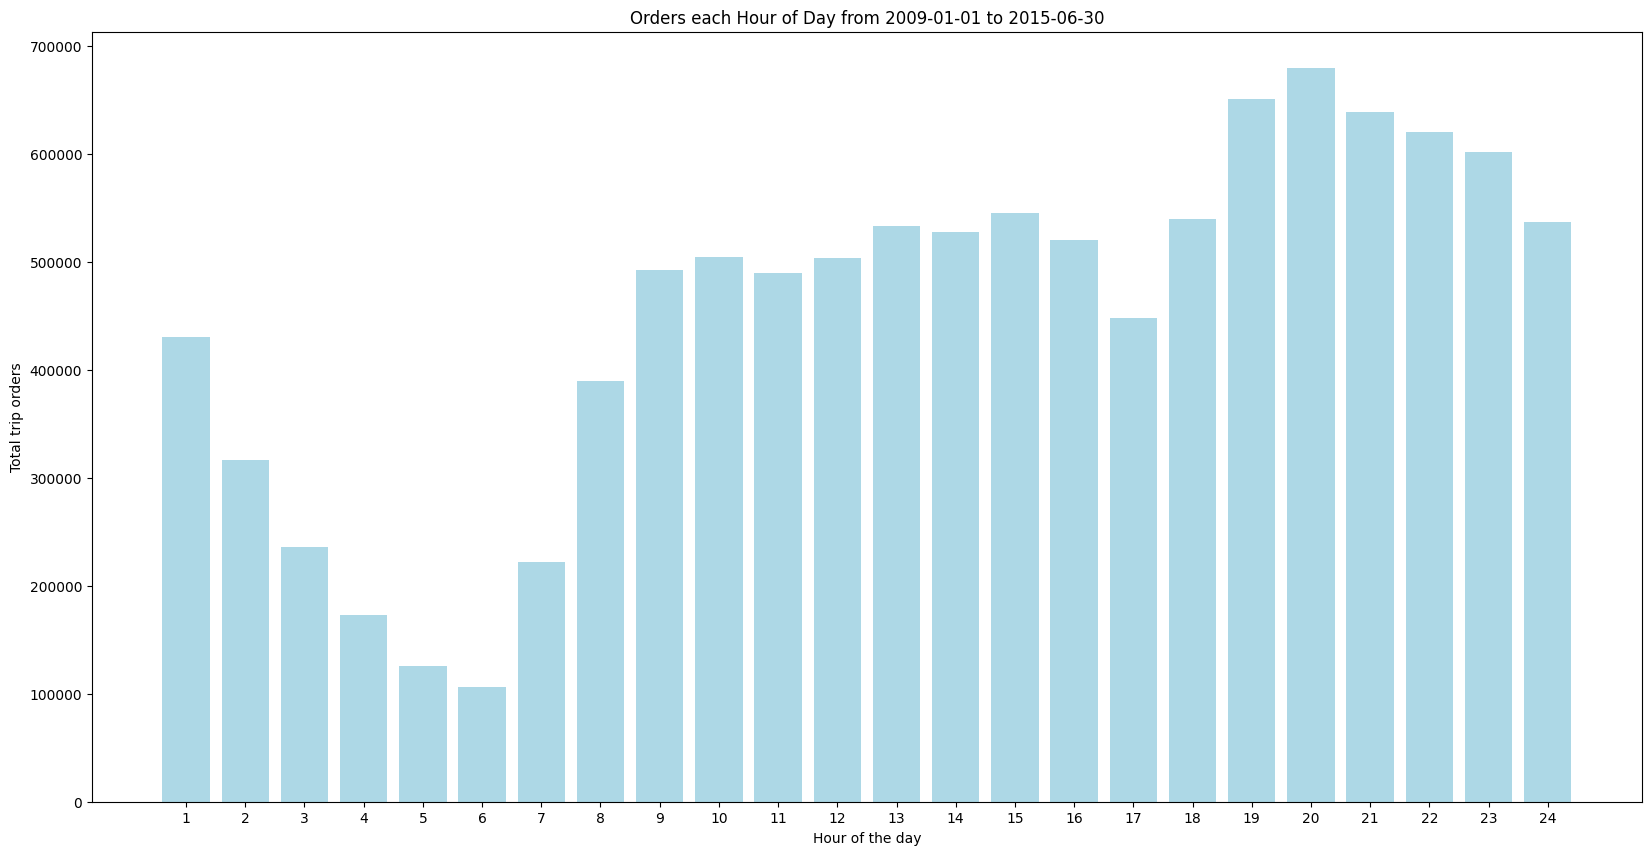

In [39]:
#calling the functions for visualization
dataframe_query_1 = get_data_for_visual_1()
plot_visual_query_1(dataframe_query_1)

### Visualization 2: Who ran more? Uber or Yellow Taxi?

This visualization makes use of bar charts for comparing distance travlled by uber and yellow taxi for each month, regardless of the year with a 90% confidence interval around the mean of the visualization. 



In [40]:
def plot_visual_2(dataframe):
    """"
    Plotting bar chart to see mean distance for each month by boht uber and yellow and taxis
    """
    dataframe= merged_dataframe
   
    compare_plot = merged_dataframe.plot(kind="bar", yerr = 0.09)
    compare_plot.set_ylabel('distance travelled')

In [41]:
def get_data_for_visual_2():
    """"
    getting data for the plot defined above
    """
    dataframe_yellow_taxis = pd.read_sql_table('taxi_trips', engine)
    dataframe_yellow_taxis["month"] = dataframe_yellow_taxis["tpep_pickup_date"].apply(lambda x:x.month)
   
    grouped_by_month_taxi = dataframe_yellow_taxis[['distance','month']].groupby('month')
    new_dataframe_yellow_taxis = grouped_by_month_taxi.mean()
   
   
    dataframe_uber_trips = pd.read_sql_table('uber_trips', engine)
    dataframe_uber_trips["month"] = dataframe_uber_trips["order_date"].apply(lambda x:x.month)
   
    grouped_by_month_uber = dataframe_uber_trips[['distance','month']].groupby('month')
    new_dataframe_uber_trips = grouped_by_month_uber.mean()
   
    merged_dataframe = new_dataframe_yellow_taxis.merge(new_dataframe_uber_trips, how = "outer", on='month')

    merged_dataframe = merged_dataframe.rename(columns={'distance_x': 'Yellow Taxis Distance', 
                                                        'distance_y': 'Uber Trips Distance'})
   
   
    return merged_dataframe

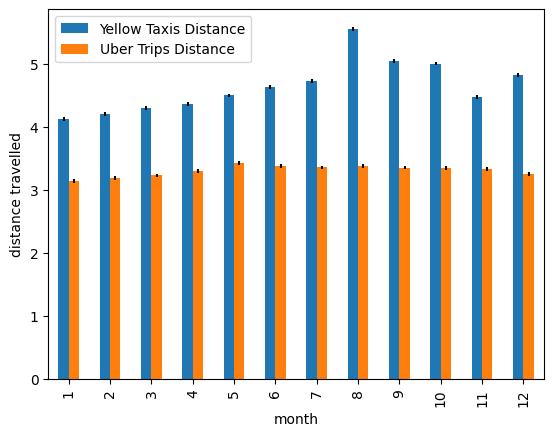

In [42]:
#calling the functions for visualization
merged_dataframe = get_data_for_visual_2()
plot_visual_2(merged_dataframe)

### Visualization 3: Hire before you Fly!

This visualization defines three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR compares what day of the week was most popular for drop offs for each airport. 

In [43]:
def get_data_for_visual_3():
    """"
    Getting data for each airport based on the query below.
    """
    query_script =  """
    SELECT dropoff_location,
        tpep_pickup_day as order_day
    FROM taxi_trips
    WHERE dropoff_location != "Non-Airport"
    """
    
    dataframe = pd.read_sql(query_script, engine)
    df_for_visualization = dataframe.pivot_table(index='dropoff_location', columns='order_day',aggfunc=len, fill_value=0)
    
    return df_for_visualization

In [44]:
def plot_visual_3(dataframe):
    """
    Plotting data for each airport based on the number of trips for each week of the day. 
    """
    dataframe.plot(kind='bar')

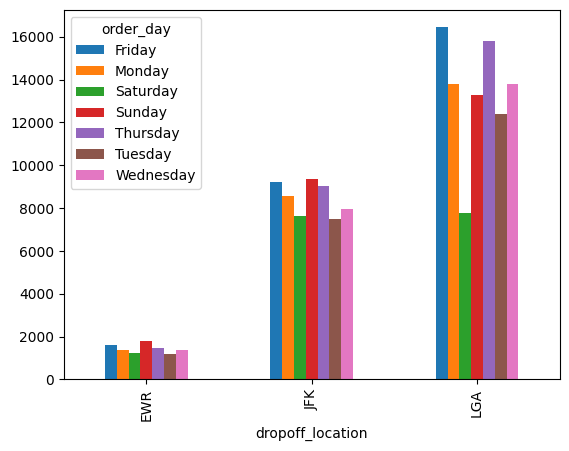

In [45]:
#calling the functions for visualization
dataframe_3 = get_data_for_visual_3()
plot_visual_3(dataframe_3)

### Visualization 4: Animated New York HeatMap for Number of Trips

This visualization has an animated heatmap of all hired trips over a map of the area defined by the box coordiantes. 
NOTE: The user must select a date for when they want to see the hired trips. 
This simplification is made to systematically observe the heat gradient in a span of 24 hours for the specified data. 
Another justification is the total number of data points is very large so such a simplification enables better interpretation by the viewer.

In [52]:
def plot_for_heatmap_for_hiredtrips(dataframe):
    """
    Plotting an animated heatmap for the hired trips
    """
    dataframe_taxitrips_heatmap= dataframe
    coordinates_list = []
    add_lat_lon = []
    
    for hour in range(24):
        #add_lat_lon=[]
        for id_hour, value in dataframe_taxitrips_heatmap[dataframe_taxitrips_heatmap['tpep_pickup_hour'] == hour].iterrows():
            add_lat_lon.append([value['pickup_latitude'],value['pickup_longitude']])
        coordinates_list.append(add_lat_lon)
        
    heatmap_animated=folium.Map(location=[(ny_lat0+ny_lat1)/2,(ny_lon0+ny_lon1)/2],zoom_start=10.5, width=850,height=550)
    HeatMapWithTime(coordinates_list,radius=5,position='bottomright',auto_play=True).add_to(heatmap_animated)
    
    return heatmap_animated

In [47]:
def get_data_for_heatmap_for_hiredtrips():
    """
    Getting data to plot heatmap for the hired trips. Please change the value of 'tpep_pickup_date' below to a desired date
    and observe the map change over time. Ensure the date is entered in 'YYYY-MM-DD' format. 
    """
    dataframe_taxitrips_heatmap = pd.read_sql_table('taxi_trips', engine)
    dataframe_taxitrips_heatmap = dataframe_taxitrips_heatmap[dataframe_taxitrips_heatmap['tpep_pickup_date']=='2009-01-01']
    dataframe_taxitrips_heatmap = dataframe_taxitrips_heatmap[['id','tpep_pickup_hour','pickup_longitude', 'pickup_latitude']]
    
    return dataframe_taxitrips_heatmap

In [48]:
#calling the functions for visualization
dataframe_taxitrips_heatmap = get_data_for_heatmap_for_hiredtrips()
plot_for_heatmap_for_hiredtrips(dataframe_taxitrips_heatmap)

### Visualization 5: How much for the distance?

This visualization scatter plot that compares tip amount versus distance for Yellow Taxi rides

In [49]:
def plot_visual_5(dataframe):
    """
    Filtering data based on reasonable tip_amount between $0 and $8, 
    number of datapoints for $8 and above were less than $8 and below
    and trip_distance less than 8km
    """
    dataframe_taxi_trips = dataframe
        
    scatterplot_tips = dataframe_taxi_trips.plot.scatter(x='distance',y='tip_amount', 
                                                         xlim = (0,8), ylim = (0,6),
                                                         s = 0.05, figsize=(20,10))
    scatterplot_tips.set_xlabel('Distance of Trip in km')
    scatterplot_tips.set_ylabel('Tip Amount')
    scatterplot_tips.set_title('Scatter Plot to Compare Tip versus Distance for Yellow Taxi Rides')
    return scatterplot_tips


In [50]:
def get_data_for_visual_5():
    """
    Getting data for the plot above
    """
    dataframe_taxi_trips = pd.read_sql_table('taxi_trips', engine)

    return dataframe_taxi_trips

<AxesSubplot: title={'center': 'Scatter Plot to Compare Tip versus Distance for Yellow Taxi Rides'}, xlabel='Distance of Trip in km', ylabel='Tip Amount'>

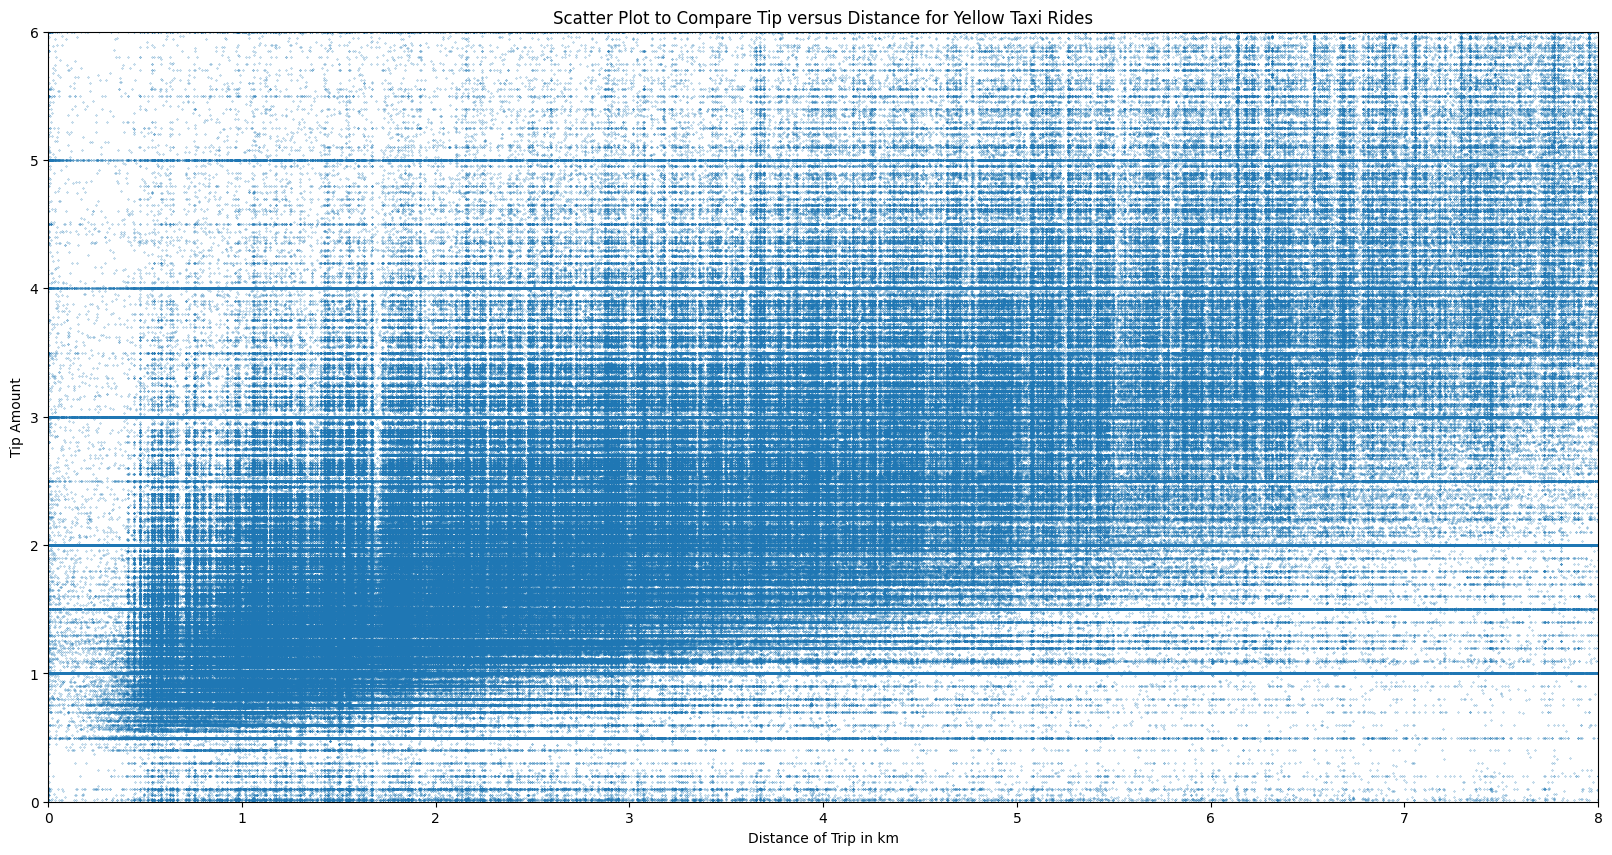

In [51]:
#calling the functions for visualization
dataframe_taxi_trips = get_data_for_visual_5()
plot_visual_5(dataframe_taxi_trips)